In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from numpy.polynomial import Polynomial
from scipy.interpolate import pchip, PchipInterpolator, interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Zadanie 2
Przygotowanie danych do interpolacji. Wczytaj dane z pliku CSV lub innych źródeł danych. Zidentyfikuj i obsłuż brakujące wartości danych. Przeprowadź wstępną analizę danych w celu określenia odpowiedniej metody interpolacji.


In [2]:
df = pd.read_csv("symulowane_dane_z_brakami.csv")

In [3]:
print(df.isnull().sum())

czas        0
wartość    10
dtype: int64


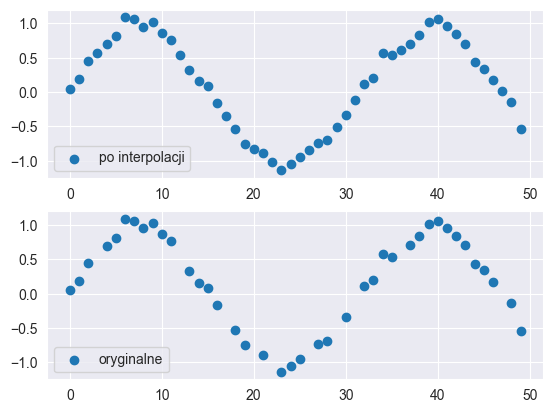

In [4]:
df_interp = df.interpolate(method = 'linear')


plt.subplot(2,1,1)
plt.scatter(df['czas'],df_interp['wartość'], label = 'po interpolacji')
plt.legend()
plt.subplot(2,1,2)
plt.scatter(df['czas'],df['wartość'], label = 'oryginalne')
plt.legend()
plt.show()


### Zadanie 3 <br>
Prognozowanie temperatury z danymi meteorologicznymi. Przygotuj funkcję do wygenerowania przykładowych danych do pliku weather_data.csv. Wczytaj dane z pliku CSV lub
innych źródeł (internetowych). Zidentyfikuj i obsłuż brakujące wartości danych. Wykorzystaj metodę interpolacji splajnów B-sklejanych do prognozowania temperatury na podstawie danych meteorologicznych z różnych stacji pomiarowych.

tworzenie fuknkcji ktora generuje przykładowe dane do pliku

In [7]:
def generate_data():
    dni = pd.date_range(start='2020-01-01', periods=100, freq='D')
    stacje = ['Stacja_A', 'Stacja_B', 'Stacja_C']

    dane = []
    for stacja in stacje:
        temperatura = np.random.uniform(-5, 5, 100)
        base_temp = np.random.uniform(-5, 5)
        temperatura = base_temp + 20 * np.sin(np.linspace(0, 3 * np.pi, 100)) + np.random.normal(0, 1.5, 100)
        temperatura[np.random.choice(100, 10, replace=False)] = np.nan
        dane.append(pd.DataFrame({'data': dni, 'temperatura': temperatura, 'stacja': stacja}))

    df_lonczony = pd.concat(dane, ignore_index = True)
    df_lonczony.to_csv('weather_data1.csv', index=False)
    print("Plik został zapisany")
generate_data()

Plik został zapisany


In [15]:
df = pd.read_csv("weather_data1.csv", parse_dates=["data"])

print(df.groupby("stacja")["temperatura"].apply(lambda x: x.isnull().sum()))

stacja
Stacja_A    10
Stacja_B    10
Stacja_C    10
Name: temperatura, dtype: int64


In [30]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

def interpolate_bsplines(df, stacja):
    df_stacja = df[df['stacja'] == stacja].copy()
    df_stacja.sort_values('data', inplace=True)
    df_stacja.reset_index(drop=True, inplace=True)

    # konwertuję daty na liczby
    x_oryginalny = (df_stacja['data'] - df_stacja['data'].min()).dt.days.values
    y = df_stacja['temperatura'].values

    x_clean= []
    y_clean = []

    x_null = []
    y_null = []
    data_null = []


    for i in range(len(y)):
        if not np.isnan(y[i]):
            x_clean.append(x_oryginalny[i])
            y_clean.append(y[i])
        else:
            data_null.append(df_stacja['data'].iloc[i])

    x_clean = np.array(x_clean)
    y_clean = np.array(y_clean)

    # interpolacja B-spline
    spline = make_interp_spline(x_clean, y_clean, k=3)
    y_interp = spline(x_oryginalny)

    y_null_interp = []
    for d in data_null:
         day_num = (d - df_stacja['data'].min()).days   # obliczamy numer dnia
         y_pred = spline(day_num)   # interpolujemy w tym dniu
         y_null_interp.append(y_pred)



    df_stacja['temperatura_interp'] = y_interp
    return df_stacja, data_null, y_null_interp


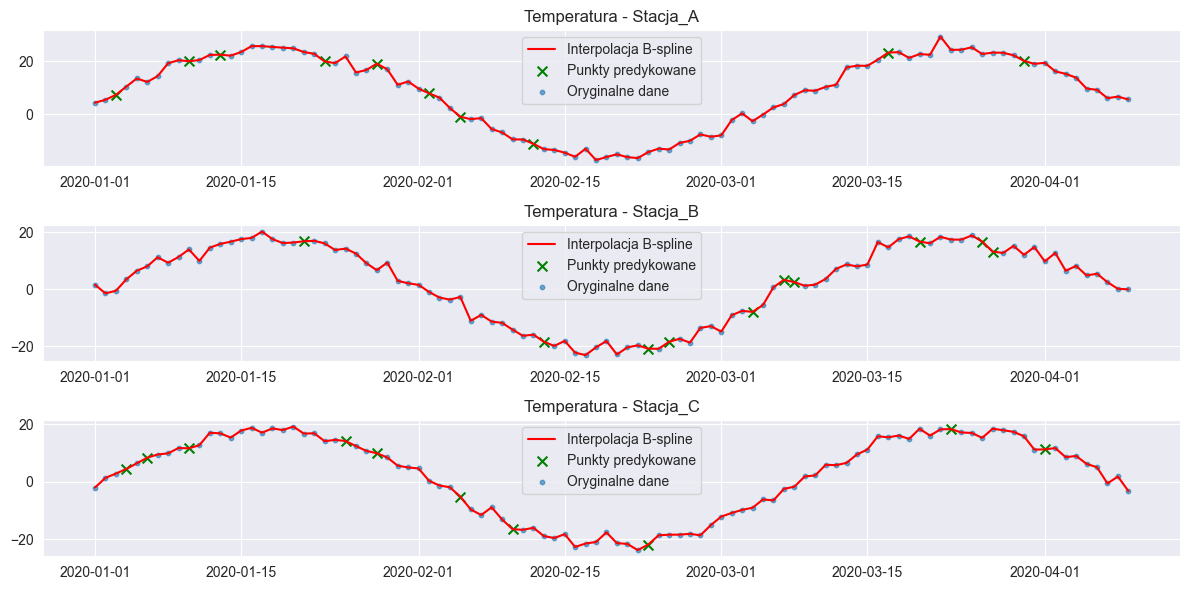

In [31]:
plt.figure(figsize=(12, 6))

for i, stacja in enumerate(df['stacja'].unique()):
    df_interp, data_null, y_null_interp = interpolate_bsplines(df, stacja)

    plt.subplot(3, 1, i+1)
    plt.plot(df_interp['data'], df_interp['temperatura_interp'], label='Interpolacja B-spline', color='red')
    plt.scatter(data_null, y_null_interp, label='Punkty predykowane', color='green', s=50, marker='x')
    plt.scatter(df_interp['data'], df_interp['temperatura'], label='Oryginalne dane', s=10, alpha=0.6)
    plt.title(f'Temperatura - {stacja}')
    plt.legend()

plt.tight_layout()
plt.show()


### Zadanie 5 <br>
Analiza trendów cen akcji. Zastosuj metodę interpolacji kubicznej Hermite'a do analizy
trendów cen akcji z dużego zbioru danych giełdowych. Zidentyfikuj lokalne maksima i minima w cenach akcji oraz przewidywane zmiany trendów. Porównaj różne stopnie interpolacji i oceń ich wpływ na dokładność analizy trendów

        Date       AAPL     AMZN      GOOGL        IBM       INTC       MSFT  \
0 2014-12-31  24.554003  15.5175  26.406752  98.992561  27.842751  39.806469   
1 2015-01-02  24.320440  15.4260  26.351517  99.992134  27.896461  40.072128   
2 2015-01-05  23.635284  15.1095  25.849415  98.418755  27.581888  39.703640   
3 2015-01-06  23.637508  14.7645  25.211466  96.296272  27.067839  39.120895   
4 2015-01-07  23.968958  14.9210  25.137320  95.666931  27.635603  39.617939   

         MSI      NVDA       TSLA  Dni  
0  56.614353  0.481179  14.827333    0  
1  56.133293  0.483099  14.620667    2  
2  54.909500  0.474939  14.006000    5  
3  54.445309  0.460540  14.085333    6  
4  54.377796  0.459340  14.063333    7  


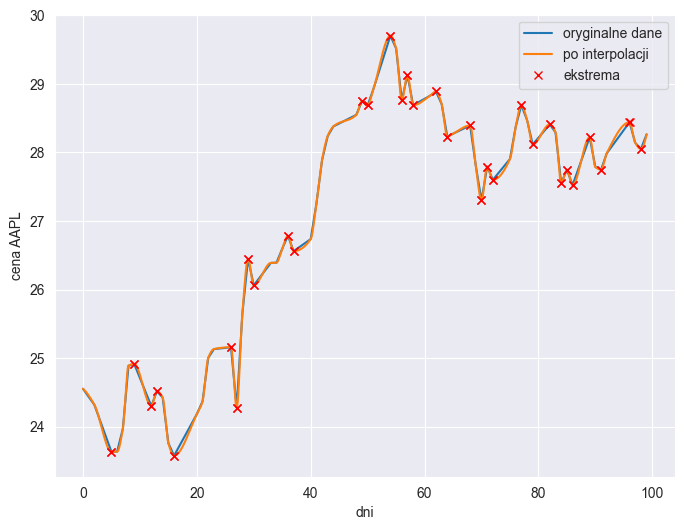

In [9]:
df = pd.read_csv('stocks_data.csv', parse_dates=['Date'])

df['Dni'] = (df['Date'] - df['Date'].min()).dt.days
df_100_dni = df[df['Dni'] < 100]
print(df.head())
t = df_100_dni['Dni']
price = df_100_dni['AAPL']


#tworzenie interpolatora
pchip = PchipInterpolator(t, price)
t_dense = np.linspace(min(t), max(t), 10000)

prices_interp = pchip(t_dense)

# liczymy pochodną i potem pochodną w punktach
pchip_derivative = pchip.derivative()
prices_der = pchip_derivative(t_dense)

signs = np.sign(prices_der)
zero_crossings = np.where(np.diff(signs) != 0)[0]

extrema_t = t_dense[zero_crossings]
wartości = pchip(extrema_t)


pchip_second_derivative = pchip.derivative(2)
extrema_second_der = pchip_second_derivative(extrema_t)
extrema_type = []
for val in extrema_second_der:
    if val < 0:
        extrema_type.append('maksimum lokalne')
    else:
        extrema_type.append('minimum lokalne')

plt.figure(figsize=(8, 6))
plt.plot(t, price, label = 'oryginalne dane')
plt.plot(t_dense, prices_interp, label = 'po interpolacji')
plt.plot(extrema_t, wartości, 'rx', label = 'ekstrema')
plt.xlabel("dni")
plt.ylabel("cena AAPL")
plt.legend()
plt.show()
